In [2]:
import json
import re
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, NullLocator, FixedLocator

In [14]:
def get_number_of_parameters(num_hidden_units):
		"""
		Following Belkin's definition for number of parameters in the network for MNIST (dimension = 784, number of classes = 10),
		get the number of parameters in a model with num_hidden_units number of hidden units.
		params:
			num_hidden_units: (int)
		return (int)
		"""
		return (784 + 1) * num_hidden_units + (num_hidden_units + 1) * 10


def load_data(*paths):
	"""
	Load data from runs. Data should be in format outputted from run of experiment.
	params:
		paths: (str) paths to folders containing run folders.
	return: (dict, list) combined metric dict and sorted list containing number of hidden units in each model used in run
	"""
	num_hidden_units = []
	model_metrics = {}
	for run_path in paths:
		for path, directories, files in os.walk(run_path):
			for file in files:
				if re.search(r".*json", file) is not None:
					with open(f"{path}/{file}", "r") as openfile:
						num_hidden_unit = re.findall('\d+', file)[0]
						if f"model_{num_hidden_unit}" in model_metrics:
							model_metrics[f"model_{num_hidden_unit}"].append(json.load(openfile))
						else:
							num_hidden_units.append(int(num_hidden_unit))
							model_metrics[f"model_{num_hidden_unit}"] = [json.load(openfile)]
	combined_metrics = {}
	for model_size, metrics in model_metrics.items():
		train_losses = np.zeros(len(metrics[0]["train_loss"]))
		test_losses = np.zeros(len(metrics[0]["test_loss"]))
		for run in metrics:
			train_losses += np.array(run["train_loss"])
			test_losses += np.array(run["test_loss"])					
		combined_metrics[model_size] = {"train_loss": train_losses / len(metrics),
				  						 "test_loss": test_losses / len(metrics)}
	return combined_metrics, sorted(num_hidden_units)


def plot_train_and_test_losses(metrics, num_hidden, title):
		train_losses = [0 for _ in range(len(num_hidden))]
		test_losses = [0 for _ in range(len(num_hidden))]
		for model in metrics:
				model_index = num_hidden.index(int(model[6:]))
				train_losses[model_index] = metrics[model]["train_loss"][-1]
				test_losses[model_index] = metrics[model]["test_loss"][-1]
				
		num_parameters = [get_number_of_parameters(i) for i in num_hidden]
		fig, ax = plt.subplots(1,1)
		ax.set_xscale('log', base=10)
		ax.tick_params(axis='x', rotation=45, which="minor")
		ax.xaxis.set_minor_locator(FixedLocator([3000, 10000, 40000, 100000, 300000, 400000]))
		ax.xaxis.set_major_locator(NullLocator())
		ax.xaxis.set_minor_formatter(ScalarFormatter())
		ax.set_ylim(0,1)

		ax.plot(num_parameters, train_losses, label="Train loss", color="tab:orange")
		ax.plot(num_parameters, test_losses, marker="o", label="Test loss", color="tab:blue")
		ax.set_xlabel("Number of parameters")
		ax.set_ylabel("Loss")
		ax.set_title(title)
		ax.legend()


def plot_training_progression(model_metrics, num_hidden_units, plot_train=True, plot_test=False):
		fig, ax = plt.subplots(1,1)
		ax.set_ylim(0,1)

		if type(num_hidden_units) is not list:
				num_hidden_units = [num_hidden_units]

		if plot_train:
			train_label = "train: "
			ax.set_title("Train loss throughout training")
		if plot_test:
				test_label = "test: "
				ax.set_title("Test loss throughout training")
		if plot_train and plot_test:
				ax.set_title("Train and test loss throughout model training")

		for num in num_hidden_units:
				num_params = get_number_of_parameters(num)
				model_training_metrics = model_metrics[f"model_{num}"]
				if plot_train:
						ax.plot(model_training_metrics["train_loss"], label=f"{train_label + str(num_params)}")
				if plot_test:
						ax.plot(model_training_metrics["test_loss"], label=f"{test_label + str(num_params)}", linestyle="--")

		ax.set_ylabel("Loss")
		ax.set_xlabel("Epoch")
		ax.legend()

In [21]:
reuse_model_metrics, reuse_num_hidden_units = load_data("./models/weight_reuse/seed1/",
                                            "./models/weight_reuse/seed2/",
                                            "./models/weight_reuse/seed3/")

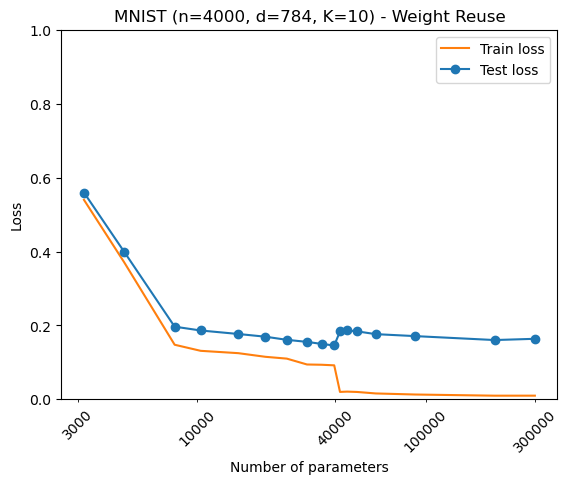

In [22]:
plot_train_and_test_losses(reuse_model_metrics, reuse_num_hidden_units, "MNIST (n=4000, d=784, K=10) - Weight Reuse")

In [23]:
no_reuse_model_metrics, no_reuse_num_hidden_units = load_data("./models/no_weight_reuse/seed1/",
                                             "./models/no_weight_reuse/seed2/",
                                             "./models/no_weight_reuse/seed3/",
                                             "./models/no_weight_reuse/seed4/")

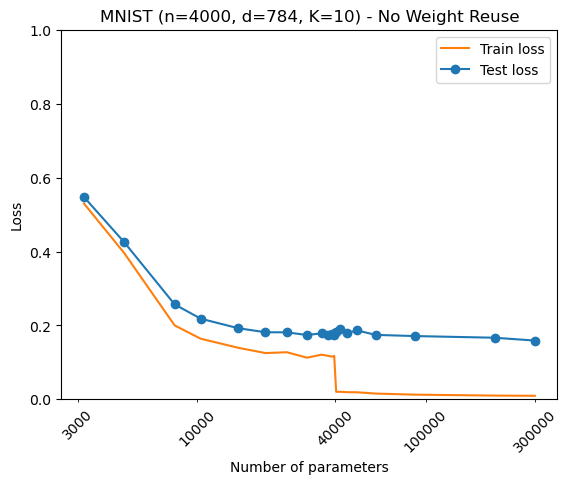

In [24]:
plot_train_and_test_losses(no_reuse_model_metrics, no_reuse_num_hidden_units, "MNIST (n=4000, d=784, K=10) - No Weight Reuse")

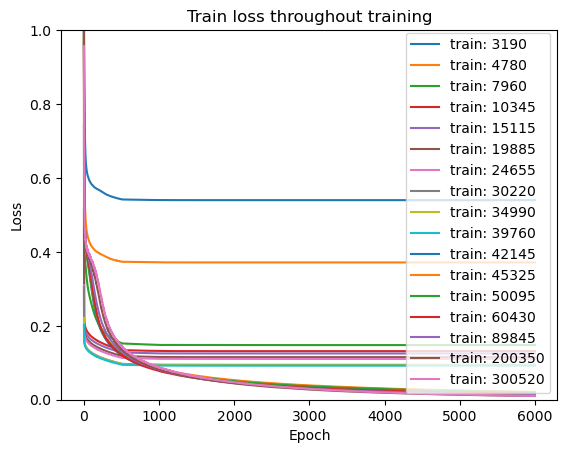

In [26]:
plot_training_progression(reuse_model_metrics, reuse_num_hidden_units, plot_train=True, plot_test=False)